# Lab - CarPark Vacancy
Reference: Dataset was extracted from one of the KlangValley shopping mall (updated to Nov 2018)

Exercise: 
1. Predict the carpark vacant status in Zone A.




In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import shutil


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.feature_column import feature_column_v2 as fc

## Reading dataset

In [2]:
df_all = pd.read_csv("https://github.com/chailing/trainerdata/raw/master/VacantBays.csv")
print('All dataset: {}'.format(df_all.shape))

df = df_all
print('Sep - Feb dataset: {}'.format(df.shape))



All dataset: (15501, 9)
Sep - Feb dataset: (15501, 9)


## Cleanup & prepare data

In [3]:
#Cleanup numbers

cleanup_nums = {"A": {"FULL": 0},
                "B": {"FULL": 0},
                "C": {"FULL": 0},
                "G": {"FULL": 0},
                "H": {"FULL": 0},
                "P": {"FULL": 0},
                "U": {"FULL": 0},
               }

df.replace(cleanup_nums, inplace=True)
df.dropna(subset=['A','B','C','G','H','P','U'])
print(df.shape)

(15501, 9)


In [4]:
# Convert to datetime

df['A'] = df['A'].astype(np.float64)
df['B'] = df['B'].astype(np.float64)
df['C'] = df['C'].astype(np.float64)
df['G'] = df['G'].astype(np.float64)
df['H'] = df['H'].astype(np.float64)
df['P'] = df['P'].astype(np.float64)
df['U'] = df['U'].astype(np.float64)
df['DateTime'] =  pd.to_datetime(df['DateTime'])
df.dtypes

DateTime      datetime64[ns]
IsoWeekday             int64
A                    float64
B                    float64
C                    float64
G                    float64
H                    float64
P                    float64
U                    float64
dtype: object

In [5]:
# Extract Hour and Minute
df['Hour'] = df.DateTime.apply(lambda x: x.hour)
df['Minute'] = df.DateTime.apply(lambda x: x.minute)
df.head()

,DateTime,IsoWeekday,A,B,C,G,H,P,U,Hour,Minute
0,2018-09-20 01:32:30.850890,4,770.0,2592.0,875.0,1410.0,1455.0,310.0,811.0,1,32
1,2018-09-20 01:39:01.932373,4,773.0,2590.0,876.0,1415.0,1459.0,310.0,810.0,1,39
2,2018-09-20 01:39:40.024931,4,773.0,2591.0,876.0,1414.0,1459.0,310.0,810.0,1,39
3,2018-09-20 01:39:52.258908,4,773.0,2591.0,876.0,1415.0,1459.0,310.0,810.0,1,39
4,2018-09-20 01:40:49.225890,4,773.0,2590.0,876.0,1412.0,1458.0,310.0,810.0,1,40


## Classify the carpark vacant status 


In [6]:
df.describe()

,IsoWeekday,A,B,C,G,H,P,U,Hour,Minute
count,15501.000000,15415.000000,15414.000000,15415.000000,15408.000000,15409.000000,15408.000000,15413.000000,15501.000000,15501.000000
mean,3.998581,704.462991,1434.660633,730.117418,793.190680,797.931209,209.521223,496.244339,11.490549,22.506806
std,1.993440,607.467157,1073.310776,672.026296,566.210323,582.460440,106.322034,287.991933,6.929934,16.765946
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,76.000000,281.000000,59.000000,212.000000,197.000000,119.000000,234.000000,5.000000,15.000000
50%,4.000000,738.000000,1585.000000,731.000000,861.000000,857.000000,257.000000,552.000000,11.000000,30.000000
75%,6.000000,1053.000000,2564.000000,1083.000000,1389.000000,1413.000000,304.000000,785.000000,18.000000,39.000000
max,7.000000,1792.000000,2646.000000,1956.000000,1503.000000,1525.000000,317.000000,831.000000,23.000000,46.000000


In [7]:
# Define status for Carpark Zone A
def A_state(x):
    if x > 1053:
        return 4 # you are early!
    elif x > 738:
        return 3 # plenty of vacancy
    elif x > 76:
        return 2 # limited bay
    elif x > 0:
        return 1 # good luck
    else:
        return 0
    
df['A_State'] = df['A'].apply(A_state)
df.head()

,DateTime,IsoWeekday,A,B,C,G,H,P,U,Hour,Minute,A_State
0,2018-09-20 01:32:30.850890,4,770.0,2592.0,875.0,1410.0,1455.0,310.0,811.0,1,32,3
1,2018-09-20 01:39:01.932373,4,773.0,2590.0,876.0,1415.0,1459.0,310.0,810.0,1,39,3
2,2018-09-20 01:39:40.024931,4,773.0,2591.0,876.0,1414.0,1459.0,310.0,810.0,1,39,3
3,2018-09-20 01:39:52.258908,4,773.0,2591.0,876.0,1415.0,1459.0,310.0,810.0,1,39,3
4,2018-09-20 01:40:49.225890,4,773.0,2590.0,876.0,1412.0,1458.0,310.0,810.0,1,40,3


## Split into dataset of: Train, Validation, Test (70%-20%-10%)

In [8]:
df_train0, df_valid0, df_test0 = np.split(df.sample(frac=1), [int(.7*len(df)), int(.9*len(df))])

# select only Featured columns
df_train = df_train0[['A_State','Hour','Minute','IsoWeekday']]
df_valid = df_valid0[['A_State','Hour','Minute','IsoWeekday']]
df_test = df_test0[['A_State','Hour','Minute','IsoWeekday']]

print('Train set: {}'.format(df_train.shape))
print('Validate set: {}'.format(df_valid.shape))
print('Test set: {}'.format(df_test.shape))



Train set: (10850, 4)
Validate set: (3100, 4)
Test set: (1551, 4)


## Feature & Label 

In [9]:
FEATURES_NUM = ['Hour','Minute','IsoWeekday']
LABEL = 'A_State'
NUM_CLASSES = 5

In [10]:
model = tf.keras.Sequential()
# Input - Layer
model.add(layers.Dense(32, activation = tf.keras.activations.relu, input_shape=(3,))) # 3 is cause of 3 features
# Hidden - Layers
#model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
#model.add(layers.Dense(64, activation = "relu"))
#model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
model.add(layers.Dense(64, activation = tf.keras.activations.relu))
#model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
# Output- Layer
model.add(layers.Dense(5, activation = tf.keras.activations.softmax)) # 5 categories

model.summary()
          
model.compile(
    #optimizer = tf.keras.optimizers.RMSprop(lr=0.01),
    #loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(lr=0.001),
    loss = tf.keras.losses.categorical_crossentropy,   
    metrics = ["accuracy"]
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 2,565
Trainable params: 2,565
Non-trainable params: 0
_________________________________________________________________


In [11]:
#print(df_train.drop([LABEL], axis=1).values)
#print(df_train[LABEL].values.reshape((10850,-1)))

history = model.fit(
 df_train.drop([LABEL], axis=1), 
 tf.keras.utils.to_categorical(df_train[LABEL], NUM_CLASSES),
 epochs= 50,
 batch_size = 32,
 validation_data = (df_valid.drop([LABEL], axis=1), 
                    tf.keras.utils.to_categorical(df_valid[LABEL]))
)

Train on 10850 samples, validate on 3100 samples
Epoch 1/50
10850/10850 [==============================] - 1s 83us/sample - loss: 1.4335 - acc: 0.4057 - val_loss: 1.2701 - val_acc: 0.4287
Epoch 2/50
10850/10850 [==============================] - 1s 60us/sample - loss: 1.2207 - acc: 0.4853 - val_loss: 1.2014 - val_acc: 0.4832
Epoch 3/50
10850/10850 [==============================] - 1s 59us/sample - loss: 1.1561 - acc: 0.5185 - val_loss: 1.1381 - val_acc: 0.5442
Epoch 4/50
10850/10850 [==============================] - 1s 58us/sample - loss: 1.1094 - acc: 0.5420 - val_loss: 1.1099 - val_acc: 0.5329
Epoch 5/50
10850/10850 [==============================] - 1s 49us/sample - loss: 1.0668 - acc: 0.5666 - val_loss: 1.0521 - val_acc: 0.5713
Epoch 6/50
10850/10850 [==============================] - 1s 48us/sample - loss: 1.0269 - acc: 0.5886 - val_loss: 1.0340 - val_acc: 0.5545
Epoch 7/50
10850/10850 [==============================] - 1s 47us/sample - loss: 0.9893 - acc: 0.6090 - val_loss: 0.9

In [12]:
print("Test-Accuracy:", np.mean(history.history["val_acc"]))


Test-Accuracy: 0.7031162


In [13]:
score = model.evaluate(df_test.drop([LABEL], axis=1).values, 
                       tf.keras.utils.to_categorical(df_test[LABEL], NUM_CLASSES), 
                       batch_size=32)
score

1551/1551 [==============================] - 0s 84us/sample - loss: 0.6766 - acc: 0.7344


[0.6765560167286182, 0.7343649]

In [14]:
result = model.predict(df_test.drop([LABEL], axis=1), 
                       batch_size=32)
result

array([[5.1959204e-03, 1.6950203e-02, 7.9348409e-01, 1.7908707e-01,
        5.2826791e-03],
       [1.8550886e-04, 9.4067931e-10, 3.0381407e-05, 2.5183948e-07,
        9.9978381e-01],
       [2.2466628e-02, 5.4810081e-02, 8.0227304e-01, 6.4831853e-02,
        5.5618402e-02],
       ...,
       [4.5209870e-01, 4.7994664e-01, 6.7086801e-02, 8.4610004e-04,
        2.1756903e-05],
       [1.1481686e-02, 2.4015587e-02, 8.3115613e-01, 7.5204417e-02,
        5.8142159e-02],
       [2.4535763e-07, 6.7045085e-11, 3.7793971e-03, 9.8876405e-01,
        7.4562794e-03]], dtype=float32)

In [15]:
df_test.tail() #head / tail

,A_State,Hour,Minute,IsoWeekday
3404,0,14,0,4
13170,2,16,0,1
4176,0,15,0,5
7407,2,9,15,4
13799,3,5,30,1


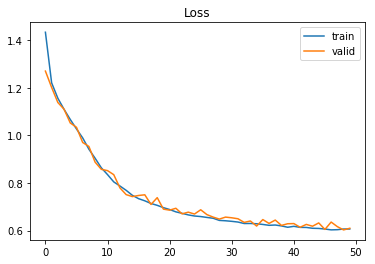

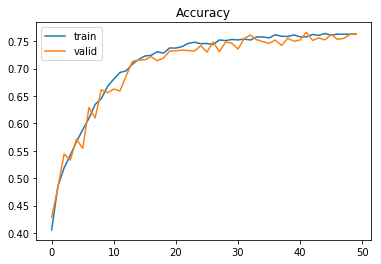

In [16]:
from matplotlib import pyplot

# plot loss during training
pyplot.subplot(111)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='valid')
pyplot.legend()
pyplot.show()

# plot accuracy during training
pyplot.subplot(111)
pyplot.title('Accuracy')
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='valid')
pyplot.legend()
pyplot.show()

## Determine metrics for validation - Accuracy

In [17]:
def print_accuracy(model, df):
  metrics = model.evaluate(input_fn = tf.estimator.inputs.pandas_input_fn(
    x = df,
    y = df[LABEL],
    batch_size = 128,
    shuffle = False
  ))
  print('Accuracy on dataset = {}'.format(metrics['accuracy']))
    
#print_accuracy(model, df_valid)

## Model: DNN Classifier

In [18]:
# DNNClassifier
OUTDIR = 'carparkClass_trained'
tf.logging.set_verbosity(tf.logging.INFO)
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

model = tf.estimator.DNNClassifier(
    hidden_units = [512, 256, 128], 
    feature_columns = [tf.feature_column.numeric_column('Hour'),
                       tf.feature_column.numeric_column('Minute'),
                       tf.feature_column.numeric_column('IsoWeekday')
                      ], 
    activation_fn = tf.nn.relu,
    n_classes=5,
    optimizer=tf.train.AdamOptimizer(
      learning_rate=0.01,
      #l1_regularization_strength=0.001
    ),
    #loss_reduction='weighted_sum',
    model_dir = OUTDIR,
#    config=tf.estimator.RunConfig(save_summary_steps=2,
#                                  save_checkpoints_steps=2)
)

model.train(input_fn = tf.estimator.inputs.pandas_input_fn(
    x = df_train,
    y = df_train[LABEL],
    batch_size = 128,
    num_epochs = 50,
    shuffle = True
  ));

print_accuracy(model, df_valid)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'carparkClass_trained', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000000007D996A0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized aut

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into carparkClass_trained\model.ckpt.
INFO:tensorflow:loss = 257.44077, step = 1
INFO:tensorflow:global_step/sec: 148.383
INFO:tensorflow:loss = 147.09409, step = 101 (0.670 sec)
INFO:tensorflow:global_step/sec: 206.632
INFO:tensorflow:loss = 90.74088, step = 201 (0.483 sec)
INFO:tensorflow:global_step/sec: 174.233
INFO:tensorflow:loss = 88.79198, step = 301 (0.575 sec)
INFO:tensorflow:global_step/sec: 171.544
INFO:tensorflow:loss = 89.080215, step = 401 (0.582 sec)
INFO:tensorflow:global_step/sec: 160.016
INFO:tensorflow:loss = 78.015755, step = 501 (0.625 sec)
INFO:tenso

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-12-13T16:43:53Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from carparkClass_trained\model.ckpt-4239
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-12-13-16:43:53
INFO:tensorflow:Saving dict for global step 4239: accuracy = 0.766129, average_loss = 0.56270874, global_step = 4239, loss = 69.77589
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4239: carparkClass_trained\model.ckpt-4239
Accuracy on dataset = 0.7661290168762207


## Prediction 

In [19]:
predictions = model.predict(input_fn = tf.estimator.inputs.pandas_input_fn(
#    x = pd.DataFrame({
#                      'Hour':[9,10,12],
#                      'Minute':[0,0,0],
#                      'IsoWeekday':[4,4,5]}),
    x = df_test,
    y = None,
    batch_size = 64,
    shuffle = False
  ))

for items in predictions:
  print(items)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from carparkClass_trained\model.ckpt-4239
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
{'logits': array([-4.3864307, -2.1918292,  2.7903621,  1.2068939, -2.45051  ],
      dtype=float32), 'probabilities': array([6.2725868e-04, 5.6305425e-03, 8.2089633e-01, 1.6849880e-01,
       4.3471674e-03], dtype=float32), 'class_ids': array([2], dtype=int64), 'classes': array([b'2'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([ 3.419917 , -9.840439 ,  0.82258  , -3.0247197, 11.386607 ],
      dtype=float32), 'probabilities': array([3.4669568e-04, 6.0401623e-10, 2.5819001e-05, 5.5090669e-07,
       9.9962699e-01], dtype=float32), 'class_ids': array([4], dtype=int64), 'classes': array([b'4'], dtype=object), 'all_class_ids'

       9.9991477e-01], dtype=float32), 'class_ids': array([4], dtype=int64), 'classes': array([b'4'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([ 0.40074554,  4.287722  ,  3.7173197 , -4.6451035 , -7.116168  ],
      dtype=float32), 'probabilities': array([1.2930596e-02, 6.3053763e-01, 3.5644159e-01, 8.3221275e-05,
       7.0317633e-06], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-3.4402056 , -0.97622705,  1.4907428 , -0.49679297, -0.5388763 ],
      dtype=float32), 'probabilities': array([0.0053067 , 0.0623615 , 0.735035  , 0.10072383, 0.09657297],
      dtype=float32), 'class_ids': array([2], dtype=int64), 'classes': array([b'2'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0'

       9.9943632e-01], dtype=float32), 'class_ids': array([4], dtype=int64), 'classes': array([b'4'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-3.462288  , -8.157751  ,  2.8745155 ,  5.6222043 , -0.07944083],
      dtype=float32), 'probabilities': array([1.0623680e-04, 9.7064674e-07, 6.0022425e-02, 9.3674117e-01,
       3.1291521e-03], dtype=float32), 'class_ids': array([3], dtype=int64), 'classes': array([b'3'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([ 2.590692  ,  2.8082213 , -0.40669426, -5.9029565 , -1.45274   ],
      dtype=float32), 'probabilities': array([4.3277654e-01, 5.3794205e-01, 2.1603068e-02, 8.8617409e-05,
       7.5896787e-03], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_class

       4.9749501e-03], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-1.5334725 , -8.161866  ,  0.7337285 ,  4.7247972 ,  0.64653635],
      dtype=float32), 'probabilities': array([1.8456501e-03, 2.4404762e-06, 1.7814852e-02, 9.6400970e-01,
       1.6327331e-02], dtype=float32), 'class_ids': array([3], dtype=int64), 'classes': array([b'3'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([ 2.2163072 ,  3.2290483 , -0.02437201, -5.840538  , -1.7803867 ],
      dtype=float32), 'probabilities': array([2.5785047e-01, 7.0989770e-01, 2.7431736e-02, 8.1719307e-05,
       4.7383364e-03], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_class

      dtype=float32), 'class_ids': array([2], dtype=int64), 'classes': array([b'2'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([ 2.7267895,  2.824129 , -0.4132482, -6.0858436, -1.5721295],
      dtype=float32), 'probabilities': array([4.6312425e-01, 5.1047158e-01, 2.0044556e-02, 6.8931760e-05,
       6.2907268e-03], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-1.26744   , -8.797385  , -0.72850156,  1.5353281 ,  3.8296168 ],
      dtype=float32), 'probabilities': array([5.4721111e-03, 2.9372532e-06, 9.3802176e-03, 9.0236381e-02,
       8.9490837e-01], dtype=float32), 'class_ids': array([4], dtype=int64), 'classes': array([b'4'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1'

       9.9992144e-01], dtype=float32), 'class_ids': array([4], dtype=int64), 'classes': array([b'4'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([ -1.6218758 , -10.271495  ,  -0.24166265,   5.5703573 ,
         2.0508025 ], dtype=float32), 'probabilities': array([7.2811951e-04, 1.2756186e-07, 2.8948206e-03, 9.6772021e-01,
       2.8656725e-02], dtype=float32), 'class_ids': array([3], dtype=int64), 'classes': array([b'3'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([ 2.1403708 ,  2.0634136 ,  0.08180532, -4.157593  , -2.044918  ],
      dtype=float32), 'probabilities': array([0.4829462 , 0.44717407, 0.06164177, 0.00088864, 0.00734938],
      dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array

       9.2241359e-01], dtype=float32), 'class_ids': array([4], dtype=int64), 'classes': array([b'4'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([  0.11804017, -10.452414  ,  -0.99998426,   5.8180084 ,
         1.8131838 ], dtype=float32), 'probabilities': array([3.2719052e-03, 8.3967464e-08, 1.0696677e-03, 9.7783488e-01,
       1.7823471e-02], dtype=float32), 'class_ids': array([3], dtype=int64), 'classes': array([b'3'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-2.288538  , -6.9298143 ,  0.21312803,  1.6266884 ,  2.3090043 ],
      dtype=float32), 'probabilities': array([6.1495700e-03, 5.9314905e-05, 7.5042024e-02, 3.0846506e-01,
       6.1028403e-01], dtype=float32), 'class_ids': array([4], dtype=int64), 'classes': array([b'4'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all

      dtype=float32), 'class_ids': array([2], dtype=int64), 'classes': array([b'2'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-2.6727343, -4.888437 , -0.5897652, -0.4924006,  2.8079598],
      dtype=float32), 'probabilities': array([3.8759720e-03, 4.2277866e-04, 3.1117341e-02, 3.4299470e-02,
       9.3028438e-01], dtype=float32), 'class_ids': array([4], dtype=int64), 'classes': array([b'4'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([ 2.5632362 ,  2.7181864 , -0.39303902, -5.7396064 , -1.4769288 ],
      dtype=float32), 'probabilities': array([4.4693646e-01, 5.2184290e-01, 2.3246190e-02, 1.1075600e-04,
       7.8636548e-03], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1'

       7.7167912e-03], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-1.2835035,  0.7759448,  1.5029181, -2.3172388, -2.2425463],
      dtype=float32), 'probabilities': array([0.03875452, 0.3038991 , 0.6287093 , 0.01378405, 0.01485304],
      dtype=float32), 'class_ids': array([2], dtype=int64), 'classes': array([b'2'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-4.7146254, -3.5133255,  2.4362683,  2.0865462, -1.2437351],
      dtype=float32), 'probabilities': array([4.52358741e-04, 1.50383788e-03, 5.76868296e-01, 4.06625181e-01,
       1.45502845e-02], dtype=float32), 'class_ids': array([2], dtype=int64), 'classes': array([b'2'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1

      dtype=float32), 'class_ids': array([2], dtype=int64), 'classes': array([b'2'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-3.4298522 , -6.1067166 ,  2.235     ,  4.4277935 ,  0.22364807],
      dtype=float32), 'probabilities': array([3.4321204e-04, 2.3605618e-05, 9.9032246e-02, 8.8734967e-01,
       1.3251274e-02], dtype=float32), 'class_ids': array([3], dtype=int64), 'classes': array([b'3'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-2.3114526, -6.592399 ,  1.81507  ,  3.5970647,  1.4265568],
      dtype=float32), 'probabilities': array([2.1134946e-03, 2.9228719e-05, 1.3095652e-01, 7.7810389e-01,
       8.8796936e-02], dtype=float32), 'class_ids': array([3], dtype=int64), 'classes': array([b'3'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1'

      dtype=float32), 'class_ids': array([2], dtype=int64), 'classes': array([b'2'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([ 0.7111752,  2.5369818,  2.5297241, -2.2021558, -5.26287  ],
      dtype=float32), 'probabilities': array([7.4473761e-02, 4.6231824e-01, 4.5897502e-01, 4.0435209e-03,
       1.8945611e-04], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([ 1.5852199,  3.6740825,  2.0662315, -4.2075315, -5.2823725],
      dtype=float32), 'probabilities': array([9.3479559e-02, 7.5491524e-01, 1.5122283e-01, 2.8507350e-04,
       9.7310367e-05], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2

      dtype=float32), 'class_ids': array([2], dtype=int64), 'classes': array([b'2'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-2.8731267 , -1.3248948 ,  1.3892521 , -1.9758077 , -0.43036032],
      dtype=float32), 'probabilities': array([0.0110327 , 0.05188843, 0.7830861 , 0.02706341, 0.12692931],
      dtype=float32), 'class_ids': array([2], dtype=int64), 'classes': array([b'2'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-2.3477435 , -4.3724623 , -0.46647337, -0.27947742,  2.7282388 ],
      dtype=float32), 'probabilities': array([5.6904079e-03, 7.5130974e-04, 3.7339505e-02, 4.5017343e-02,
       9.1120148e-01], dtype=float32), 'class_ids': array([4], dtype=int64), 'classes': array([b'4'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3

      dtype=float32), 'class_ids': array([2], dtype=int64), 'classes': array([b'2'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-3.3798962 , -1.1260384 ,  2.2686744 , -0.31204075, -2.220941  ],
      dtype=float32), 'probabilities': array([0.00313389, 0.02984845, 0.8896659 , 0.06736536, 0.00998646],
      dtype=float32), 'class_ids': array([2], dtype=int64), 'classes': array([b'2'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-4.7411885, -5.4084845,  2.5128446, -1.5342867,  1.093606 ],
      dtype=float32), 'probabilities': array([5.6116562e-04, 2.8793077e-04, 7.9337329e-01, 1.3862153e-02,
       1.9191551e-01], dtype=float32), 'class_ids': array([2], dtype=int64), 'classes': array([b'2'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'

       4.1052452e-03], dtype=float32), 'class_ids': array([3], dtype=int64), 'classes': array([b'3'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-3.0179458 , -2.2144525 ,  0.87880504, -0.6302734 ,  0.07888532],
      dtype=float32), 'probabilities': array([0.01169709, 0.02612345, 0.57599026, 0.1273593 , 0.2588299 ],
      dtype=float32), 'class_ids': array([2], dtype=int64), 'classes': array([b'2'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-2.9438624, -7.1683483,  1.8117034,  4.254774 ,  1.1679614],
      dtype=float32), 'probabilities': array([6.596708e-04, 9.652867e-06, 7.667314e-02, 8.823794e-01,
       4.027816e-02], dtype=float32), 'class_ids': array([3], dtype=int64), 'classes': array([b'3'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'

       8.7665188e-01], dtype=float32), 'class_ids': array([4], dtype=int64), 'classes': array([b'4'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-4.058812 , -2.5815573,  2.5802305,  1.7870219, -1.9967092],
      dtype=float32), 'probabilities': array([0.00089016, 0.00389969, 0.6804031 , 0.3078082 , 0.00699885],
      dtype=float32), 'class_ids': array([2], dtype=int64), 'classes': array([b'2'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([ -1.7534746 , -11.945421  ,   0.14262125,   6.6824183 ,
         1.9576597 ], dtype=float32), 'probabilities': array([2.1467774e-04, 8.0441591e-09, 1.4297197e-03, 9.8957521e-01,
       8.7803574e-03], dtype=float32), 'class_ids': array([3], dtype=int64), 'classes': array([b'3'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0

       9.9993157e-01], dtype=float32), 'class_ids': array([4], dtype=int64), 'classes': array([b'4'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-1.7566782, -7.7988377, -0.2531248,  1.5534124,  3.0530279],
      dtype=float32), 'probabilities': array([6.4274292e-03, 1.5274280e-05, 2.8908288e-02, 1.7603193e-01,
       7.8861707e-01], dtype=float32), 'class_ids': array([4], dtype=int64), 'classes': array([b'4'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-3.0630949 , -1.7562051 ,  1.437214  , -1.6207304 , -0.23377633],
      dtype=float32), 'probabilities': array([0.00862781, 0.03187688, 0.776891  , 0.03650159, 0.14610268],
      dtype=float32), 'class_ids': array([2], dtype=int64), 'classes': array([b'2'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1

      dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([  1.4263681, -12.877775 ,  -3.0813491,   1.2035515,   7.496866 ],
      dtype=float32), 'probabilities': array([2.3003973e-03, 1.4112121e-09, 2.5358640e-05, 1.8409190e-03,
       9.9583328e-01], dtype=float32), 'class_ids': array([4], dtype=int64), 'classes': array([b'4'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-1.4692734, -8.943567 , -0.6518121,  1.8320534,  3.6683605],
      dtype=float32), 'probabilities': array([4.9819099e-03, 2.8271650e-06, 1.1282748e-02, 1.3525206e-01,
       8.4848052e-01], dtype=float32), 'class_ids': array([4], dtype=int64), 'classes': array([b'4'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1'

       8.3822273e-03], dtype=float32), 'class_ids': array([3], dtype=int64), 'classes': array([b'3'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-1.9378697, -7.514056 ,  3.4372213,  5.7229166, -1.4220619],
      dtype=float32), 'probabilities': array([4.2697374e-04, 1.6169407e-06, 9.2209034e-02, 9.0664721e-01,
       7.1517704e-04], dtype=float32), 'class_ids': array([3], dtype=int64), 'classes': array([b'3'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([ 2.3644767 ,  2.2059233 , -0.36783615, -5.136645  , -1.4386858 ],
      dtype=float32), 'probabilities': array([5.1511908e-01, 4.3959099e-01, 3.3518087e-02, 2.8458494e-04,
       1.1487224e-02], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': 

       2.6002473e-03], dtype=float32), 'class_ids': array([3], dtype=int64), 'classes': array([b'3'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-3.2706492 , -5.8216777 ,  1.6883062 ,  3.4969184 , -0.21985519],
      dtype=float32), 'probabilities': array([9.6725818e-04, 7.5447511e-05, 1.3778101e-01, 8.4073609e-01,
       2.0440215e-02], dtype=float32), 'class_ids': array([3], dtype=int64), 'classes': array([b'3'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-2.7776487, -6.254254 ,  2.9292433,  4.887771 , -0.6386965],
      dtype=float32), 'probabilities': array([4.0920824e-04, 1.2649513e-05, 1.2314477e-01, 8.7295890e-01,
       3.4743960e-03], dtype=float32), 'class_ids': array([3], dtype=int64), 'classes': array([b'3'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': 

      dtype=float32), 'class_ids': array([2], dtype=int64), 'classes': array([b'2'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-2.9165144, -5.688659 ,  2.6070445,  2.3097289, -0.549934 ],
      dtype=float32), 'probabilities': array([2.2304466e-03, 1.3946474e-04, 5.5878258e-01, 4.1506901e-01,
       2.3778502e-02], dtype=float32), 'class_ids': array([2], dtype=int64), 'classes': array([b'2'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([ 0.27963558, -9.194387  , -1.8311576 ,  0.49159056,  5.420537  ],
      dtype=float32), 'probabilities': array([5.7727708e-03, 4.4347431e-07, 6.9932413e-04, 7.1356776e-03,
       9.8639190e-01], dtype=float32), 'class_ids': array([4], dtype=int64), 'classes': array([b'4'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1'

{'logits': array([ 2.2232938 ,  3.2986953 ,  0.57959855, -5.5839753 , -2.7704215 ],
      dtype=float32), 'probabilities': array([2.4203572e-01, 7.0944774e-01, 4.6776932e-02, 9.8452256e-05,
       1.6411057e-03], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-3.0246875 , -0.93595874,  1.3840463 ,  0.4400018 , -0.9739387 ],
      dtype=float32), 'probabilities': array([0.00763474, 0.0616478 , 0.62731105, 0.24405606, 0.05935032],
      dtype=float32), 'class_ids': array([2], dtype=int64), 'classes': array([b'2'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([ 1.6747123,  1.682952 ,  0.1207203, -4.2881174, -1.443346 ],
      dtype=float32), 'probabilities': array([0.44121048, 0.44486097, 0.09327294, 0.00113507, 0.01952047]

       9.9992383e-01], dtype=float32), 'class_ids': array([4], dtype=int64), 'classes': array([b'4'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-0.528685 ,  0.8401245,  0.9239678, -2.5178397, -2.026959 ],
      dtype=float32), 'probabilities': array([0.1045431 , 0.41092426, 0.44686306, 0.01430265, 0.02336702],
      dtype=float32), 'class_ids': array([2], dtype=int64), 'classes': array([b'2'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([ -5.545638  , -12.13576   ,   3.6638014 ,   7.00874   ,
         0.29037607], dtype=float32), 'probabilities': array([3.4052118e-06, 4.6783257e-09, 3.4021474e-02, 9.6480924e-01,
       1.1659855e-03], dtype=float32), 'class_ids': array([3], dtype=int64), 'classes': array([b'3'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0

       2.1285566e-02], dtype=float32), 'class_ids': array([3], dtype=int64), 'classes': array([b'3'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-1.1811906,  1.831992 ,  2.5190673, -1.414644 , -4.387873 ],
      dtype=float32), 'probabilities': array([0.01596371, 0.3248945 , 0.6458554 , 0.01263997, 0.00064638],
      dtype=float32), 'class_ids': array([2], dtype=int64), 'classes': array([b'2'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-3.8859122, -2.7770045,  2.318568 ,  1.7009037, -1.5343101],
      dtype=float32), 'probabilities': array([0.00128803, 0.00390408, 0.6375253 , 0.3437552 , 0.01352738],
      dtype=float32), 'class_ids': array([2], dtype=int64), 'classes': array([b'2'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'],

      dtype=float32), 'class_ids': array([2], dtype=int64), 'classes': array([b'2'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-1.9211323 , -7.5427356 ,  0.83367026,  3.5743933 ,  0.98797655],
      dtype=float32), 'probabilities': array([3.5885840e-03, 1.2986494e-05, 5.6405112e-02, 8.7417710e-01,
       6.5816216e-02], dtype=float32), 'class_ids': array([3], dtype=int64), 'classes': array([b'3'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([ 1.2764822,  1.7363489,  0.3126248, -3.591722 , -1.5065393],
      dtype=float32), 'probabilities': array([0.3295088 , 0.5218967 , 0.12568083, 0.00253299, 0.02038056],
      dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'

       1.6177958e-02], dtype=float32), 'class_ids': array([3], dtype=int64), 'classes': array([b'3'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([-3.207122  , -6.052325  ,  2.4131846 ,  4.3018203 , -0.29932702],
      dtype=float32), 'probabilities': array([4.7177999e-04, 2.7421034e-05, 1.3019906e-01, 8.6066049e-01,
       8.6412989e-03], dtype=float32), 'class_ids': array([3], dtype=int64), 'classes': array([b'3'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_classes': array([b'0', b'1', b'2', b'3', b'4'], dtype=object)}
{'logits': array([ 2.6512582,  3.8011441,  3.2071455, -2.4350204, -6.695099 ],
      dtype=float32), 'probabilities': array([1.69273823e-01, 5.34538388e-01, 2.95126736e-01, 1.04627782e-03,
       1.47747005e-05], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object), 'all_class_ids': array([0, 1, 2, 3, 4]), 'all_class

In [20]:
df_test.head()

,A_State,Hour,Minute,IsoWeekday
6012,2,18,45,3
7562,4,0,15,6
8556,2,9,30,2
12405,1,16,45,7
944,2,21,15,6
